In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8,5)
np.random.seed(42)


In [2]:
n_users = 300

data = {
    "User_ID": np.arange(1001, 1001 + n_users),
    "Product_Category": np.random.choice(
        ["Core", "Premium", "Add-on"], n_users, p=[0.5, 0.3, 0.2]
    ),
    "Sessions_Per_Month": np.random.randint(2, 40, n_users),
    "Avg_Session_Duration_Min": np.random.randint(3, 45, n_users),
    "Monthly_Revenue": np.random.randint(0, 3000, n_users),
    "Feature_Usage_Count": np.random.randint(1, 120, n_users),
    "Customer_Tenure_Months": np.random.randint(1, 36, n_users)
}

df = pd.DataFrame(data)
df.head()


,User_ID,Product_Category,Sessions_Per_Month,Avg_Session_Duration_Min,Monthly_Revenue,Feature_Usage_Count,Customer_Tenure_Months
0,1001,Core,33,7,129,12,27
1,1002,Add-on,31,32,94,19,7
2,1003,Premium,36,32,2674,101,5
3,1004,Premium,17,19,2802,44,31
4,1005,Core,14,25,1955,59,23


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   User_ID                   300 non-null    int64 
 1   Product_Category          300 non-null    object
 2   Sessions_Per_Month        300 non-null    int64 
 3   Avg_Session_Duration_Min  300 non-null    int64 
 4   Monthly_Revenue           300 non-null    int64 
 5   Feature_Usage_Count       300 non-null    int64 
 6   Customer_Tenure_Months    300 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 16.5+ KB


Removing extremely low engagement users

In [4]:

df = df[df["Sessions_Per_Month"] > 2]
df.reset_index(drop=True, inplace=True)


Engagement Score, Feature Adoption Rate, Revenue per Session

In [5]:

df["Engagement_Score"] = (
    df["Sessions_Per_Month"] * df["Avg_Session_Duration_Min"]
)


df["Feature_Adoption_Rate"] = (
    df["Feature_Usage_Count"] / df["Customer_Tenure_Months"]
)


df["Revenue_Per_Session"] = (
    df["Monthly_Revenue"] / df["Sessions_Per_Month"]
)

df.head()


,User_ID,Product_Category,Sessions_Per_Month,Avg_Session_Duration_Min,Monthly_Revenue,Feature_Usage_Count,Customer_Tenure_Months,Engagement_Score,Feature_Adoption_Rate,Revenue_Per_Session
0,1001,Core,33,7,129,12,27,231,0.444444,3.909091
1,1002,Add-on,31,32,94,19,7,992,2.714286,3.032258
2,1003,Premium,36,32,2674,101,5,1152,20.200000,74.277778
3,1004,Premium,17,19,2802,44,31,323,1.419355,164.823529
4,1005,Core,14,25,1955,59,23,350,2.565217,139.642857


In [6]:
category_summary = df.groupby("Product_Category").agg({
    "Engagement_Score": "mean",
    "Feature_Adoption_Rate": "mean",
    "Monthly_Revenue": "mean",
    "Revenue_Per_Session": "mean"
}).round(2)

category_summary


,Engagement_Score,Feature_Adoption_Rate,Monthly_Revenue,Revenue_Per_Session
Product_Category,,,,
Add-on,565.29,5.74,1586.92,96.93
Core,506.14,7.30,1344.71,90.90
Premium,491.94,7.87,1483.75,105.88


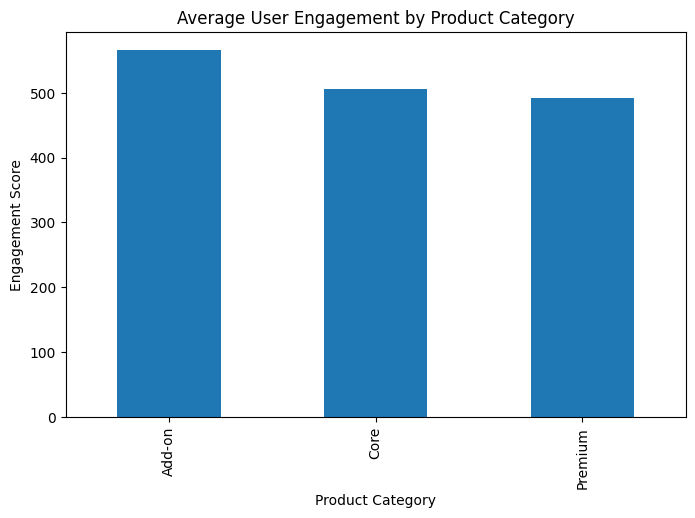

In [7]:
category_summary["Engagement_Score"].plot(kind="bar")
plt.title("Average User Engagement by Product Category")
plt.ylabel("Engagement Score")
plt.xlabel("Product Category")
plt.show()


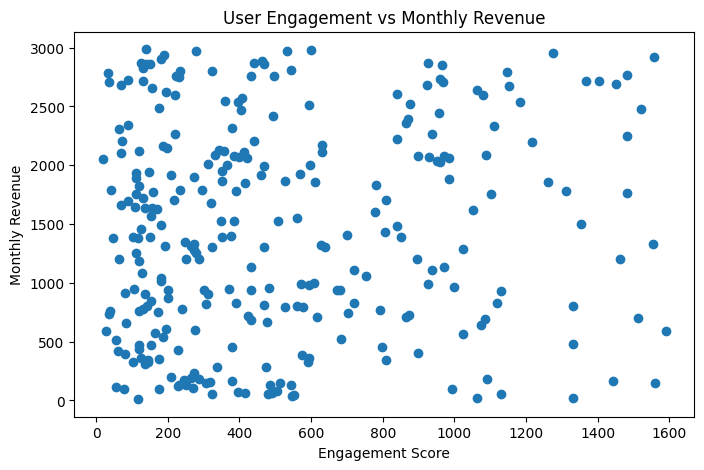

In [8]:
plt.scatter(df["Engagement_Score"], df["Monthly_Revenue"])
plt.title("User Engagement vs Monthly Revenue")
plt.xlabel("Engagement Score")
plt.ylabel("Monthly Revenue")
plt.show()


In [9]:
high_value_threshold = df["Monthly_Revenue"].quantile(0.85)

high_value_users = df[df["Monthly_Revenue"] >= high_value_threshold]

high_value_users[[
    "User_ID",
    "Product_Category",
    "Monthly_Revenue",
    "Engagement_Score"
]].head()


,User_ID,Product_Category,Monthly_Revenue,Engagement_Score
2,1003,Premium,2674,1152
3,1004,Premium,2802,323
11,1012,Add-on,2919,1558
22,1026,Premium,2730,960
25,1029,Premium,2935,189


In [10]:
low_engagement = df[
    (df["Engagement_Score"] < df["Engagement_Score"].median()) &
    (df["Customer_Tenure_Months"] < 6)
]

low_engagement[[
    "User_ID",
    "Product_Category",
    "Engagement_Score",
    "Customer_Tenure_Months"
]].head()


,User_ID,Product_Category,Engagement_Score,Customer_Tenure_Months
10,1011,Core,351,2
36,1040,Core,136,4
64,1069,Core,39,4
72,1078,Core,121,2
88,1094,Premium,128,3


In [11]:
business_insights = df.groupby("Product_Category").agg({
    "User_ID": "count",
    "Monthly_Revenue": "sum"
}).rename(columns={"User_ID": "Total_Users"}).round(0)

business_insights


,Total_Users,Monthly_Revenue
Product_Category,,
Add-on,63,99976
Core,137,184225
Premium,87,129086


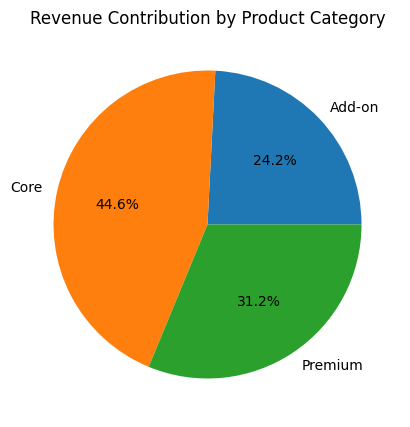

In [12]:
business_insights["Monthly_Revenue"].plot(kind="pie", autopct="%1.1f%%")
plt.title("Revenue Contribution by Product Category")
plt.ylabel("")
plt.show()


Product Opportunity Score

In [13]:
df["Product_Opportunity_Score"] = (
    0.5 * df["Engagement_Score"] +
    0.3 * df["Feature_Adoption_Rate"] +
    0.2 * df["Revenue_Per_Session"]
)

df.sort_values("Product_Opportunity_Score", ascending=False).head(10)


,User_ID,Product_Category,Sessions_Per_Month,Avg_Session_Duration_Min,Monthly_Revenue,Feature_Usage_Count,Customer_Tenure_Months,Engagement_Score,Feature_Adoption_Rate,Revenue_Per_Session,Product_Opportunity_Score
219,1228,Core,37,43,587,98,28,1591,3.500000,15.864865,799.722973
11,1012,Add-on,38,41,2919,113,14,1558,8.071429,76.815789,796.784586
47,1051,Add-on,37,42,1332,79,14,1554,5.642857,36.000000,785.892857
161,1167,Core,39,40,146,39,26,1560,1.500000,3.743590,781.198718
97,1103,Core,38,40,2482,66,15,1520,4.400000,65.315789,774.383158
235,1244,Core,36,42,701,25,26,1512,0.961538,19.472222,760.182906
195,1203,Core,38,39,2768,87,19,1482,4.578947,72.842105,756.942105
268,1279,Premium,38,39,2248,91,20,1482,4.550000,59.157895,754.196579
264,1275,Premium,39,38,1762,56,12,1482,4.666667,45.179487,751.435897
60,1065,Core,33,44,2687,116,26,1452,4.461538,81.424242,743.623310
